In [501]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

In [503]:
# Загрузка данных
df = pd.read_excel('C:/Users/User/Задания/данные/Задания_1_2.xlsx', sheet_name='Timeseries', index_col='Date', parse_dates=['Date'])
df.rename(columns=lambda a: 'series', inplace=True)

In [505]:
# Проверка на наличие NULL
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1642 entries, 2015-01-01 to 2019-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   series  1642 non-null   float64
dtypes: float64(1)
memory usage: 25.7 KB


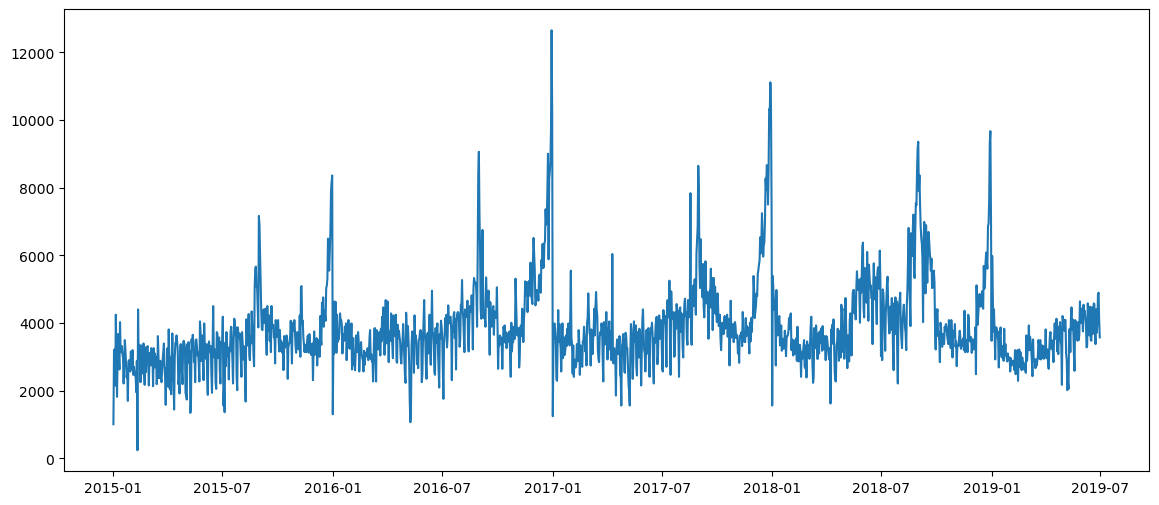

In [507]:
# Представление данных
plt.figure(figsize = (14, 6))
plt.plot(df)
plt.show()

In [509]:
from statsmodels.tsa.stattools import adfuller

# Функция для выполнения ADF теста
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Данные стационарны")
    else:
        print("Данные не стационарны")

adf_test(df['series'])

ADF Statistic: -5.496714
p-value: 0.000002
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Данные стационарны


In [511]:
# Добавление временных признаков для улучшения предсказания
def date_feature(df):
    df['dofweek'] = df.index.dayofweek 
    df['dofmonth'] = df.index.day
    df['dinmonth'] = df.index.days_in_month
    df['dtomonth'] = df['dinmonth'] - df['dofmonth']
    df['dofyear'] = df.index.dayofyear
    df['dinyear'] = (df.index + pd.tseries.offsets.YearEnd()).dayofyear
    df['dtoyear'] = df['dinyear'] - df['dofyear']
    df['minyear'] = df.index.month
    return df

df = date_feature(df)
window = 30 # сглаживаем на месяц, так как присутствуют очень резкие скачки
df['mean'] = df['series'].rolling(window).mean()
df['mean'].fillna(method='bfill', inplace=True)
df

C:\Users\User\AppData\Local\Temp\ipykernel_15212\2437219189.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['mean'].fillna(method='bfill', inplace=True)


,series,dofweek,dofmonth,dinmonth,dtomonth,dofyear,dinyear,dtoyear,minyear,mean
Date,,,,,,,,,,
2015-01-01,1006.699649,3,1,31,30,1,365,364,1,2888.504221
2015-01-02,3197.751826,4,2,31,29,2,365,363,1,2888.504221
2015-01-03,3217.491035,5,3,31,28,3,365,362,1,2888.504221
2015-01-04,2151.573759,6,4,31,27,4,365,361,1,2888.504221
2015-01-05,4243.929892,0,5,31,26,5,365,360,1,2888.504221
...,...,...,...,...,...,...,...,...,...,...
2019-06-26,4007.059387,2,26,30,4,177,365,188,6,4062.987145
2019-06-27,4836.106157,3,27,30,3,178,365,187,6,4069.566881
2019-06-28,4895.323783,4,28,30,2,179,365,186,6,4099.175695


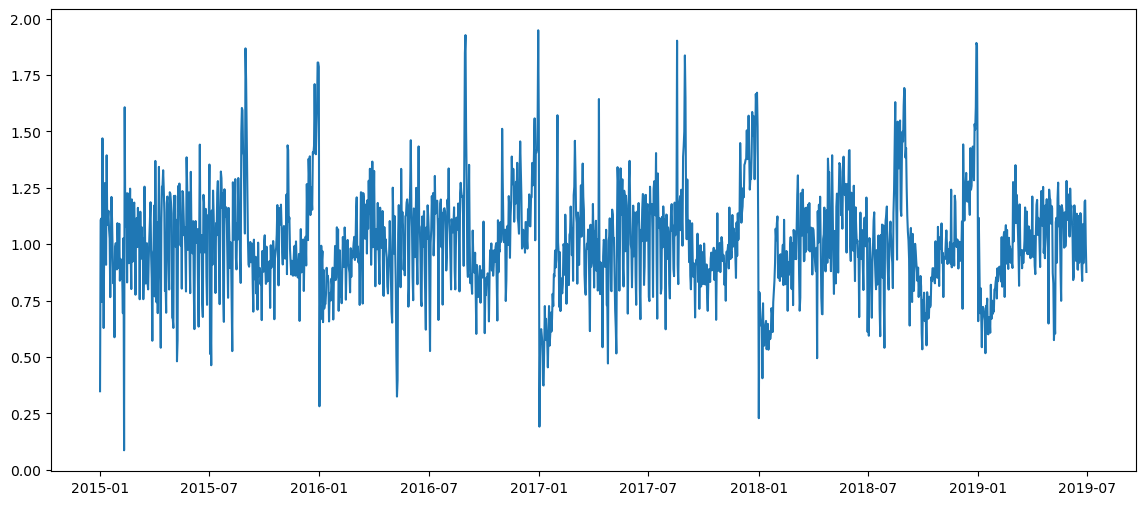

In [513]:
# Нормализация данных (так как данные довольно шумные, это улучшит процесс обучения модели)
df['series_norm'] = df['series'] / df['mean']

plt.figure(figsize = (14, 6))
plt.plot(df['series_norm'])
plt.show()

In [515]:
# Разделение данных на train и test (328 значений - 20% тестовой выборки)
train_x = df.iloc[:-328].drop(['series', 'series_norm'], axis=1)
train_y = df.iloc[:-328]['series_norm']
test_x = df.iloc[-328:].drop(['series', 'series_norm'], axis=1)
test_y = df.iloc[-328:]['series_norm']

train_x shape: (1314, 9)
train_y shape: (1314,)
test_x shape: (328, 9)
test_y shape: (328,)


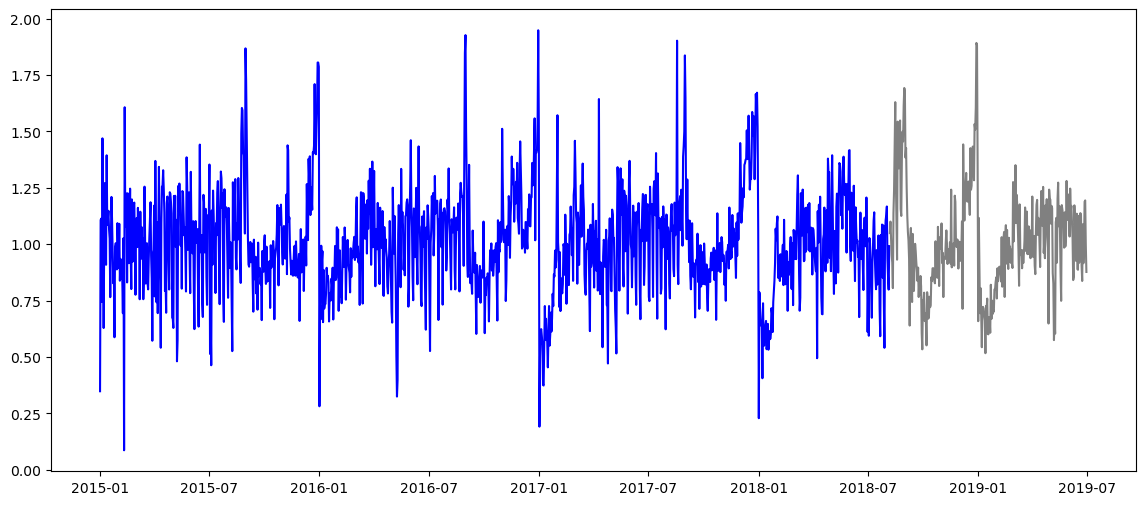

In [517]:
# Проверка форм данных
print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

plt.figure(figsize = (14, 6))
plt.plot(train_y, color='blue')
plt.plot(test_y, color='gray')
plt.show()

In [519]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet, HuberRegressor 

# Определение моделей
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor(),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Extra Trees": ExtraTreesRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "LightGBM": lgb.LGBMRegressor(),
    "MLPRegressor": MLPRegressor(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "HuberRegressor": HuberRegressor()
}

# Обучение и оценка моделей
results = {}
for name, model in models.items():
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    mse = mean_squared_error(test_y, predictions)
    mae = mean_absolute_error(test_y, predictions)
    r2 = r2_score(test_y, predictions)
    results[name] = {"MSE": mse, "MAE": mae, "R^2": r2}

# Вывод результатов
results_df = pd.DataFrame(results).T
print("\nРезультаты метрик для моделей:\n")
print(results_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 9
[LightGBM] [Info] Start training from score 1.008568

Результаты метрик для моделей:

                                MSE       MAE       R^2
Linear Regression          0.042165  0.154638  0.189522
Ridge Regression           0.043519  0.159531  0.163489
Lasso Regression           0.044411  0.163263  0.146352
Random Forest              0.028443  0.124376  0.453274
Gradient Boosting          0.025725  0.119956  0.505525
XGBoost                    0.030438  0.129840  0.414944
Support Vector Regression  0.043659  0.159105  0.160812
K-Nearest Neighbors        0.080013  0.188897 -0.537983
Extra Trees                0.024738  0.120979  0.524506
AdaBoost                   0.030981  0.141181  0.404489
Decision Tre

In [539]:
# Обучение модели
xtrees = ExtraTreesRegressor()
xtrees.fit(train_x, train_y)

ExtraTreesRegressor()

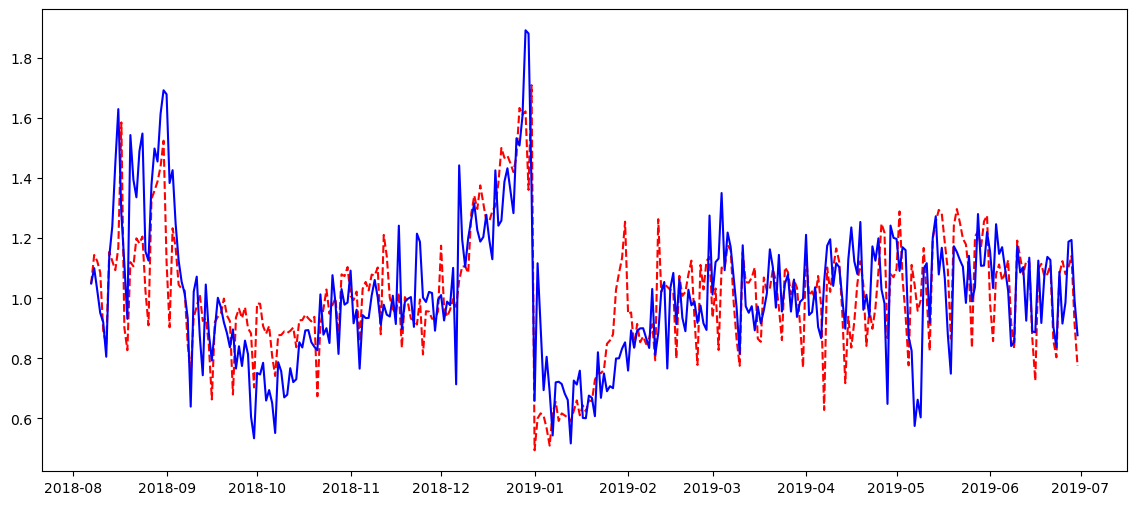

In [541]:
# Прогнозирование на тестовую выборку
predict_y = xtrees.predict(predict_x)

plt.figure(figsize = (14, 6))
plt.plot(test_y.index, predict_y, label='Test Predictions', color='red', linestyle = '--')
plt.plot(test_y.index, test_y, label='Test Predictions', color='blue')
plt.show()

Mean Squared Error (MSE): 0.0237
Mean Absolute Error (MAE): 0.1168
R-squared (R²): 0.5441


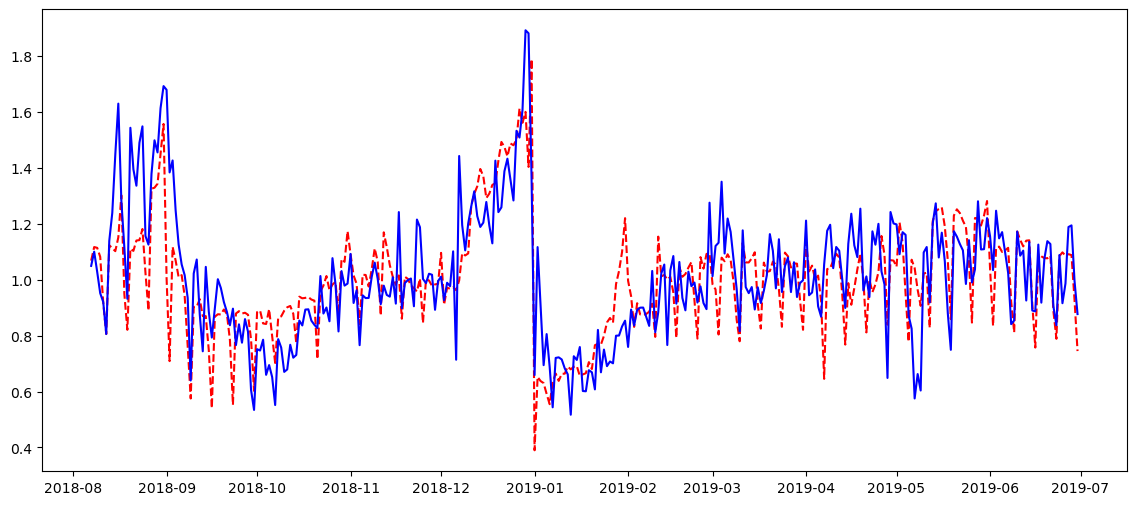

In [549]:
from sklearn.ensemble import VotingRegressor

# Комбинация моделей
model1 = GradientBoostingRegressor()
model2 = ExtraTreesRegressor()
model3 = RandomForestRegressor()

# Использование ансамблевого метода
voting_regressor = VotingRegressor(estimators=[('gb', model1), ('et', model2), ('rf', model3)])
voting_regressor.fit(train_x, train_y)

# Оценка метрик 
mse = mean_squared_error(test_y, predict_y_v) 
mae = mean_absolute_error(test_y, predict_y_v) 
r2 = r2_score(test_y, predict_y_v) 

# Вывод результатов 
print(f"Mean Squared Error (MSE): {mse:.4f}") 
print(f"Mean Absolute Error (MAE): {mae:.4f}") 
print(f"R-squared (R²): {r2:.4f}")


predict_y_v = voting_regressor.predict(predict_x)
plt.figure(figsize = (14, 6))
plt.plot(test_y.index, predict_y_v, label='Test Predictions', color='red', linestyle = '--')
plt.plot(test_y.index, test_y, label='Test Predictions', color='blue')
plt.show()

In [551]:
# Создание нового диапазона дат для прогноза до 30 сентября
end_date = '2019-09-30'
index_target = pd.date_range(start=df.index[-1] + pd.Timedelta(1, 'D'), end=end_date, freq='D')
data_target = pd.DataFrame(index=index_target)
predict_x_target = date_feature(data_target)
predict_x_target['mean'] = df['mean'].iloc[-1]

In [553]:
# Проверка форм данных для прогнозирования
print(f"predict_x_target shape: {predict_x_target.shape}")

predict_x_target shape: (92, 9)


In [555]:
# Прогноз значений
predict_y_target = voting_regressor.predict(predict_x_target)

In [557]:
# Деинверсирование нормализации для прогнозов
predict_y_target = predict_y_target * df['mean'].iloc[-1]

In [559]:
# Копирование данных и добавление прогнозируемых значений
predicted_df = df.copy()
predicted_df = pd.concat([predicted_df, data_target])
predicted_df.loc[predicted_df.index > df.index[-1], 'series'] = predict_y_target

In [561]:
# Денормализация исторических данных для корректного отображения
predicted_df.loc[predicted_df.index <= df.index[-1], 'series'] = predicted_df.loc[predicted_df.index <= df.index[-1], 'series_norm'] * predicted_df.loc[predicted_df.index <= df.index[-1], 'mean']

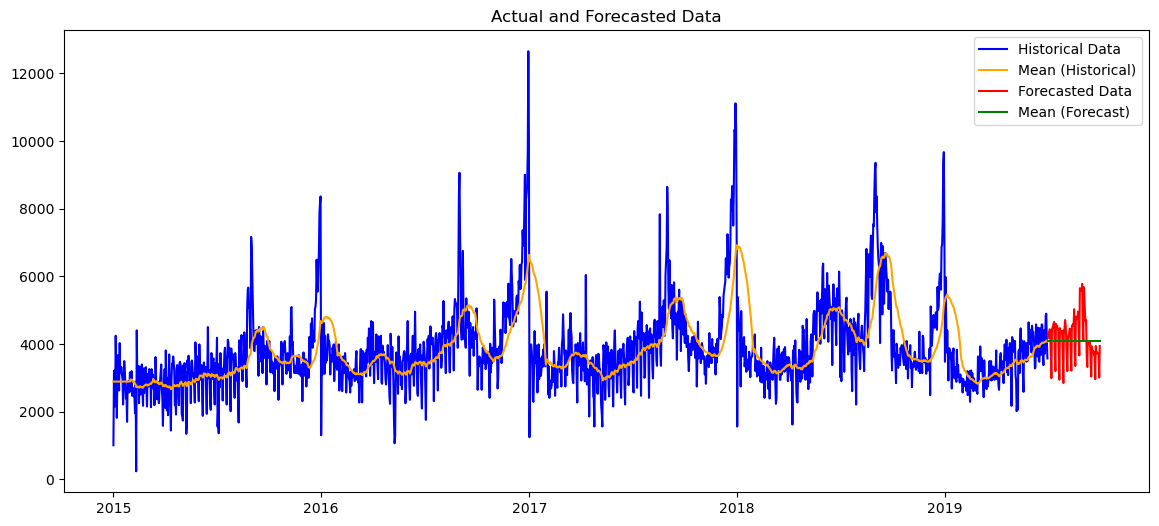

,series,dofweek,dofmonth,dinmonth,dtomonth,dofyear,dinyear,dtoyear,minyear,mean,series_norm
2019-09-26,3747.434742,3,26,30,4,269,365,96,9,4073.514723,NaN
2019-09-27,3707.906336,4,27,30,3,270,365,95,9,4073.514723,NaN
2019-09-28,3675.834492,5,28,30,2,271,365,94,9,4073.514723,NaN
2019-09-29,3004.675976,6,29,30,1,272,365,93,9,4073.514723,NaN
2019-09-30,3940.785990,0,30,30,0,273,365,92,9,4073.514723,NaN


In [563]:
# Разделение данных на исторические и прогнозируемые
historical_data = predicted_df[predicted_df.index <= df.index[-1]]
forecast_data = predicted_df[predicted_df.index > df.index[-1]]

# Построение графика
plt.figure(figsize=(14, 6))
plt.plot(historical_data.index, historical_data['series'], label='Historical Data', color='blue')
plt.plot(historical_data.index, historical_data['mean'], label='Mean (Historical)', color='orange')
plt.plot(forecast_data.index, forecast_data['series'], label='Forecasted Data', color='red')
plt.plot(forecast_data.index, forecast_data['mean'], label='Mean (Forecast)', color='green')

plt.legend()
plt.title('Actual and Forecasted Data')
plt.show()

# Отображение последних строк данных
with pd.option_context('display.max_rows', 5):
    display(predicted_df.tail())

In [565]:
# Сохранение прогнозов в Excel 
output_df = pd.DataFrame({ 'Date': predicted_df.loc[predicted_df.index > df.index[-1]].index, 'Forecasted Values': predicted_df.loc[predicted_df.index > df.index[-1], 'series'] }) 
output_df.to_excel("C:/Users/User/задания/результаты/forecasted_vector.xlsx", index=False) 
print("Прогнозы сохранены в файл 'forecasted_vector.xlsx'")

Прогнозы сохранены в файл 'forecasted_vector.xlsx'
